- Preprocesamiento: Se utiliza un ColumnTransformer que aplica una tubería de imputación y escalado a las variables numéricas y una tubería de imputación y codificación OneHot a las categóricas. Esto asegura que todo el preprocesado se realice con scikit-learn.
- Clustering: Se usa KMeans sobre las columnas latitude, longitude y price para asignar un cluster a cada registro y luego se visualizan geográficamente.
- Selección de características y PCA: Se ejemplifica la selección de las 10 mejores características para la regresión y se aplica PCA para reducir la dimensionalidad a 2 componentes.
- Modelado: Se crean dos pipelines, uno para regresión (prediciendo price) y otro para clasificación multiclase (prediciendo room_type), evaluándolos mediante validación cruzada y mostrando métricas.
- Visualizaciones: Se incluyen gráficos para EDA y para la comparación de tiempos y métricas durante la validación cruzada.

Carga y preprocesado inicial:

Se eliminan las columnas id, host_id y host_name.
Se transforma la columna de fecha (en este caso, se utiliza last_review) a tipo datetime y se descompone en columnas de año, mes y día.
Análisis Exploratorio de Datos (EDA):

Se realizan gráficos univariantes (histograma, boxplot para price y countplot para room_type).
Se incluye un gráfico bivariante (scatterplot de price vs. minimum_nights).
Se generan gráficos multivariantes (heatmap de correlaciones y pairplot con variables numéricas seleccionadas).
Preprocesamiento usando Scikit-Learn:

Se crean pipelines separados para variables numéricas (con imputación y escalado) y categóricas (con imputación y OneHotEncoding).
Todo el preprocesado se realiza con scikit-learn, cumpliendo el requisito de no usar métodos propios de pandas para estos pasos.
Clustering:

Se aplica KMeans para generar una columna cluster (usando las variables latitude, longitude y price).
Se utiliza dicha columna para colorear un scatterplot geográfico, lo que facilita el análisis visual de los grupos.
Selección de características y reducción de dimensionalidad:

Se usa SelectKBest para filtrar las mejores variables en el contexto de la regresión.
Se aplica PCA para reducir la dimensionalidad a dos componentes, lo cual es útil para visualización o análisis posterior.
Modelado:

Regresión: Se crea un pipeline que incluye el preprocesado y un modelo de regresión lineal para predecir la columna price.
Clasificación Multiclase: Se construye un pipeline similar que utiliza LogisticRegression para predecir la columna room_type.
Validación Cruzada y Comparación de Resultados:

Se realizan validaciones cruzadas para ambos modelos (regresión y clasificación) y se muestran los resultados en dataframes con las métricas calculadas.
Además, se incluyen gráficos (boxplots) opcionales que muestran los tiempos de ejecución y las métricas obtenidas en la validación cruzada.

In [ ]:
"""
Ejercicio completo:
  - Carga y preprocesado del dataset de Airbnb NYC
  - Análisis exploratorio de datos (EDA): univariado, bivariado y multivariado
  - Preprocesamiento usando scikit-learn (imputación, escalado y codificación)
  - Clustering con KMeans y visualización
  - Selección de características con SelectKBest y reducción de dimensionalidad con PCA
  - Modelado de regresión para predecir 'price'
  - Modelado de clasificación multiclase para predecir 'room_type'
  - Evaluación de modelos con validación cruzada y resumen de métricas
"""

# =============================================================================
# 1. Librerías y carga de datos
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
import time

# Cargar el dataset (asegúrate de que el archivo se encuentre en el directorio actual)
df = pd.read_csv('AB_NYC_2019.csv')
print("Dimensión original del dataset:", df.shape)

# =============================================================================
# 2. Preprocesado inicial: eliminación de columnas y manejo de fecha
# =============================================================================
# Quitar columnas: 'id', 'host_id', 'host_name'
df.drop(['id', 'host_id', 'host_name'], axis=1, inplace=True)

# Revisar columnas para identificar la columna de fecha; en este dataset se usa "last_review"
# Convertir "last_review" a datetime y descomponer en año, mes y día
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df['last_review_year']  = df['last_review'].dt.year
df['last_review_month'] = df['last_review'].dt.month
df['last_review_day']   = df['last_review'].dt.day

# Opcional: Si no se desea conservar la columna original de fecha, se puede eliminar
# df.drop('last_review', axis=1, inplace=True)

print("Columnas luego del preprocesado inicial:", df.columns.tolist())

# =============================================================================
# 3. Análisis Exploratorio de Datos (EDA)
# =============================================================================
# --- EDA Univariado ---
# Histograma de 'price'
plt.figure(figsize=(8, 4))
sns.histplot(df['price'].dropna(), bins=30, kde=True)
plt.title("Histograma de Price")
plt.xlabel("Price")
plt.ylabel("Frecuencia")
plt.show()

# Boxplot de 'price'
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['price'])
plt.title("Boxplot de Price")
plt.xlabel("Price")
plt.show()

# Countplot de la variable categórica 'room_type'
plt.figure(figsize=(6, 4))
sns.countplot(x='room_type', data=df)
plt.title("Conteo de Room Type")
plt.xlabel("Room Type")
plt.ylabel("Conteo")
plt.show()

# --- EDA Bivariado ---
# Scatterplot: price vs. minimum_nights
plt.figure(figsize=(8, 6))
sns.scatterplot(x='minimum_nights', y='price', data=df, alpha=0.5)
plt.title("Scatterplot: Price vs Minimum Nights")
plt.xlabel("Minimum Nights")
plt.ylabel("Price")
plt.show()

# --- EDA Multivariado ---
# Matriz de correlación (solo variables numéricas)
plt.figure(figsize=(12, 10))
corr = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Heatmap de Correlaciones")
plt.show()

# Pairplot (usando algunas variables numéricas de interés)
cols_pairplot = ['price', 'minimum_nights', 'number_of_reviews', 'availability_365']
sns.pairplot(df[cols_pairplot].dropna())
plt.suptitle("Pairplot de variables numéricas", y=1.02)
plt.show()

# =============================================================================
# 4. Preprocesamiento con scikit-learn: Imputación, Escalado y Codificación
# =============================================================================
# Identificar variables numéricas y categóricas
num_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Excluir la variable target en cada caso (aquí se mantienen para la transformación general)
cat_features = df.select_dtypes(include=['object']).columns.tolist()

print("Variables numéricas para preprocesamiento:", num_features)
print("Variables categóricas para preprocesamiento:", cat_features)

# Pipeline para variables numéricas
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline para variables categóricas
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer que aplica las transformaciones a cada tipo de variable
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

# Ejemplo de transformación (se podría aplicar luego a X en modelado)
X_transformed = preprocessor.fit_transform(df)
print("Forma de la matriz transformada:", X_transformed.shape)

# =============================================================================
# 5. Clustering y visualización con Siluetas
# =============================================================================
# Seleccionar características para clustering (por ejemplo: latitud, longitud y precio)
clust_features = ['latitude', 'longitude', 'price']
# En caso de valores faltantes en estas columnas, se pueden imputar con 0 o de otra manera
df_clust = df[clust_features].fillna(0)

# Pipeline: escalado y clustering con KMeans (n_clusters=3)
cluster_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=3, random_state=42))
])

# Ajustar el modelo y asignar etiquetas de cluster
df['cluster'] = cluster_pipeline.fit_predict(df_clust)
print("Conteo de clusters:\n", df['cluster'].value_counts())

# Visualización: scatterplot de latitud vs. longitud coloreado por cluster
plt.figure(figsize=(8, 6))
sns.scatterplot(x='longitude', y='latitude', hue='cluster', data=df, palette='Set1', alpha=0.6)
plt.title("Clusters geográficos (KMeans)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Cluster")
plt.show()

# =============================================================================
# 6. Feature Selection: SelectKBest y PCA (Ejemplo con regresión)
# =============================================================================
# Para la regresión se predecirá 'price'
# Separar X (todas las variables excepto 'price' y 'room_type') y y (target)
X_reg = df.drop(['price', 'room_type'], axis=1)
y_reg = df['price']

# Aplicar preprocesamiento a X_reg (la transformación de variables numéricas y categóricas)
X_reg_transformed = preprocessor.fit_transform(X_reg)
print("Forma de X para regresión luego de preprocesamiento:", X_reg_transformed.shape)

# Selección de características con SelectKBest (usando f_regression) para elegir las 10 mejores
selector = SelectKBest(score_func=f_regression, k=10)
X_reg_selected = selector.fit_transform(X_reg_transformed, y_reg)
print("Forma de X luego de SelectKBest:", X_reg_selected.shape)

# Aplicar PCA para reducción de dimensionalidad a 2 componentes (para visualización o análisis posterior)
pca = PCA(n_components=2, random_state=42)
X_reg_pca = pca.fit_transform(X_reg_transformed)
print("Forma de X luego de PCA:", X_reg_pca.shape)

# =============================================================================
# 7. Regresión: Predecir la columna 'price'
# =============================================================================
# Se crea un pipeline que incluye el preprocesador y el modelo de regresión (LinearRegression)
reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Usar validación cruzada para evaluar el modelo
# Se utilizan 5 folds y se calculan MSE y MAE (scoring negativo por convención en sklearn)
cv_results_reg = cross_validate(
    reg_pipeline,
    X_reg, y_reg,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring={'MSE': 'neg_mean_squared_error', 'MAE': 'neg_mean_absolute_error'},
    return_train_score=True,
    return_estimator=False,
    return_times=True
)

# Mostrar resultados promedio y desviación estándar
print("\n=== Resultados Regresión (LinearRegression) ===")
print("MSE (negativo): {:.3f} ± {:.3f}".format(
    np.mean(cv_results_reg['test_MSE']),
    np.std(cv_results_reg['test_MSE'])
))
print("MAE (negativo): {:.3f} ± {:.3f}".format(
    np.mean(cv_results_reg['test_MAE']),
    np.std(cv_results_reg['test_MAE'])
))

# =============================================================================
# 8. Clasificación Multiclase: Predecir la columna 'room_type'
# =============================================================================
# Separar X (todas las variables excepto 'price' y 'room_type') y y (target)
X_clf = df.drop(['price', 'room_type'], axis=1)
y_clf = df['room_type']

# Pipeline para clasificación: se usa el mismo preprocesador y LogisticRegression
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs', random_state=42))
])

# Evaluación con validación cruzada (5 folds), usando la métrica de exactitud (accuracy)
cv_results_clf = cross_validate(
    clf_pipeline,
    X_clf, y_clf,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring={'accuracy': 'accuracy'},
    return_train_score=True,
    return_times=True
)

print("\n=== Resultados Clasificación (LogisticRegression) ===")
print("Accuracy (train): {:.3f} ± {:.3f}".format(
    np.mean(cv_results_clf['train_accuracy']),
    np.std(cv_results_clf['train_accuracy'])
))
print("Accuracy (test): {:.3f} ± {:.3f}".format(
    np.mean(cv_results_clf['test_accuracy']),
    np.std(cv_results_clf['test_accuracy'])
))

# =============================================================================
# 9. Comparación de Resultados con Validación Cruzada
# =============================================================================
# Crear un DataFrame resumen para regresión
df_results_reg = pd.DataFrame({
    'MSE_train': cv_results_reg['train_MSE'],
    'MSE_test': cv_results_reg['test_MSE'],
    'MAE_train': cv_results_reg['train_MAE'],
    'MAE_test': cv_results_reg['test_MAE'],
    'fit_time': cv_results_reg['fit_time'],
    'score_time': cv_results_reg['score_time']
})
print("\n=== Resultados de Regresión por Fold ===")
print(df_results_reg)

# Crear un DataFrame resumen para clasificación
df_results_clf = pd.DataFrame({
    'accuracy_train': cv_results_clf['train_accuracy'],
    'accuracy_test': cv_results_clf['test_accuracy'],
    'fit_time': cv_results_clf['fit_time'],
    'score_time': cv_results_clf['score_time']
})
print("\n=== Resultados de Clasificación por Fold ===")
print(df_results_clf)

# Opcional: Boxplots para tiempos de ejecución y métricas (ejemplo para regresión)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_results_reg[['fit_time', 'score_time']])
plt.title("Tiempos de ejecución (Regresión)")
plt.ylabel("Tiempo (segundos)")

plt.subplot(1, 2, 2)
# Convertir métricas negativas a positivas para facilitar la interpretación
sns.boxplot(data=pd.DataFrame({
    'MSE_test': -df_results_reg['MSE_test'],
    'MAE_test': -df_results_reg['MAE_test']
}))
plt.title("Métricas (Regresión)")
plt.ylabel("Error")
plt.show()

In [ ]:
# Para rellenar las columnas

numerical_cols = X_train.select_dtypes(include=[np.number]).columns
print('numerical_cols', numerical_cols)
pipeline_numerical = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', MinMaxScaler())
])
categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns
print('categorical_cols', numerical_cols)
pipeline_categorical = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='others')),
   # ('encoder', OrdinalEncoder()),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])
pipeline_all = ColumnTransformer([
    ('numeric', pipeline_numerical, numerical_cols),
    ('categorical', pipeline_categorical, categorical_cols)
])
pipeline = make_pipeline(
    pipeline_all,
    LinearRegression()
)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
r2_score(y_test, y_pred)

-------------------------------------------------------------------

### Cargar librerias

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

* Cargar archivo CSV

In [19]:
df = pd.read_csv('data/airbnb_nyc_clean.csv')
print("Dimensión original del dataset:", df.shape)

Dimensión original del dataset: (69305, 23)


* Quitar columnas: id, name, host_id, host_name, last_review 

In [20]:
df.drop(['id','name' , 'host_id', 'host_name', 'last_review'], axis=1, inplace=True)
df.head(2)

host_identity_verified neighbourhood_group neighbourhood       lat  \
0            unconfirmed            Brooklyn    Kensington  40.64749   
1               verified           Manhattan       Midtown  40.75362   

       long  instant_bookable cancellation_policy        room_type  \
0 -73.97237             False              strict     Private room   
1 -73.98377             False            moderate  Entire home/apt   

   construction_year  price  service_fee  minimum_nights  number_of_reviews  \
0             2020.0  966.0        193.0            10.0                9.0   
1             2007.0  142.0         28.0            13.0               45.0   

   reviews_per_month  review_rate_number  calculated_host_listings_count  \
0               0.21                 4.0                             6.0   
1               0.38                 4.0                             2.0   

   availability_365                                        house_rules  
0             286.0  Clean up and treat the home the way you'd like...  
1             228.0  Pet friendly but please confirm with me if the...

In [ ]:
# Comprobamos valores nulos
df.info()
# No tenemos valores nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69305 entries, 0 to 69304
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_identity_verified          69305 non-null  object 
 1   neighbourhood_group             69305 non-null  object 
 2   neighbourhood                   69305 non-null  object 
 3   lat                             69305 non-null  float64
 4   long                            69305 non-null  float64
 5   instant_bookable                69305 non-null  bool   
 6   cancellation_policy             69305 non-null  object 
 7   room_type                       69305 non-null  object 
 8   construction_year               69305 non-null  float64
 9   price                           69305 non-null  float64
 10  service_fee                     69305 non-null  float64
 11  minimum_nights                  69305 non-null  float64
 12  number_of_reviews               

#### EDAs (10%) (menos foco para este módulo)
* univariantes: histogramas boxplot countplot

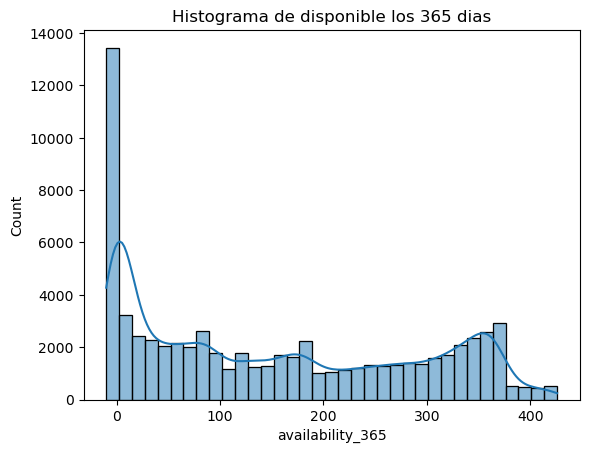

In [33]:
# Histograma de 'availability_365'
sns.histplot(df, x='availability_365', kde=True)
plt.title("Histograma de disponible los 365 dias");
plt.show()

Text(0.5, 0, 'Price')

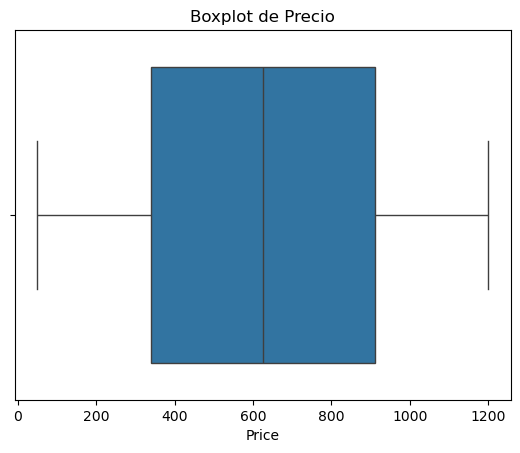

In [ ]:
# Boxplot de 'price'
sns.boxplot(x=df['price'])
plt.title("Boxplot de Precio")
plt.xlabel("Price")
plt.show()

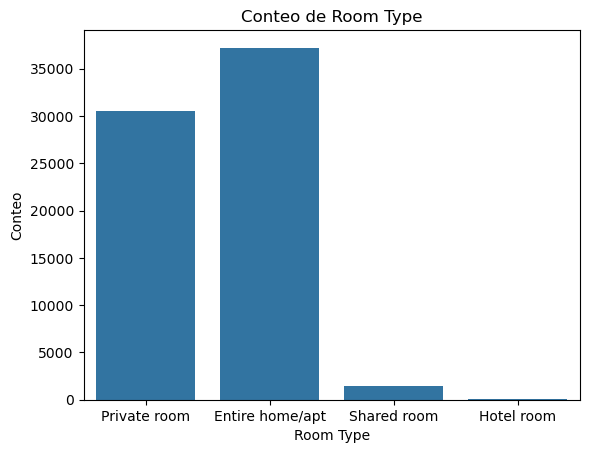

In [34]:
# Countplot de 'room_type'
sns.countplot(x='room_type', data=df)
plt.title("Conteo de Room Type")
plt.xlabel("Room Type")
plt.ylabel("Conteo")
plt.show()

   * bivariantes: scatterplot

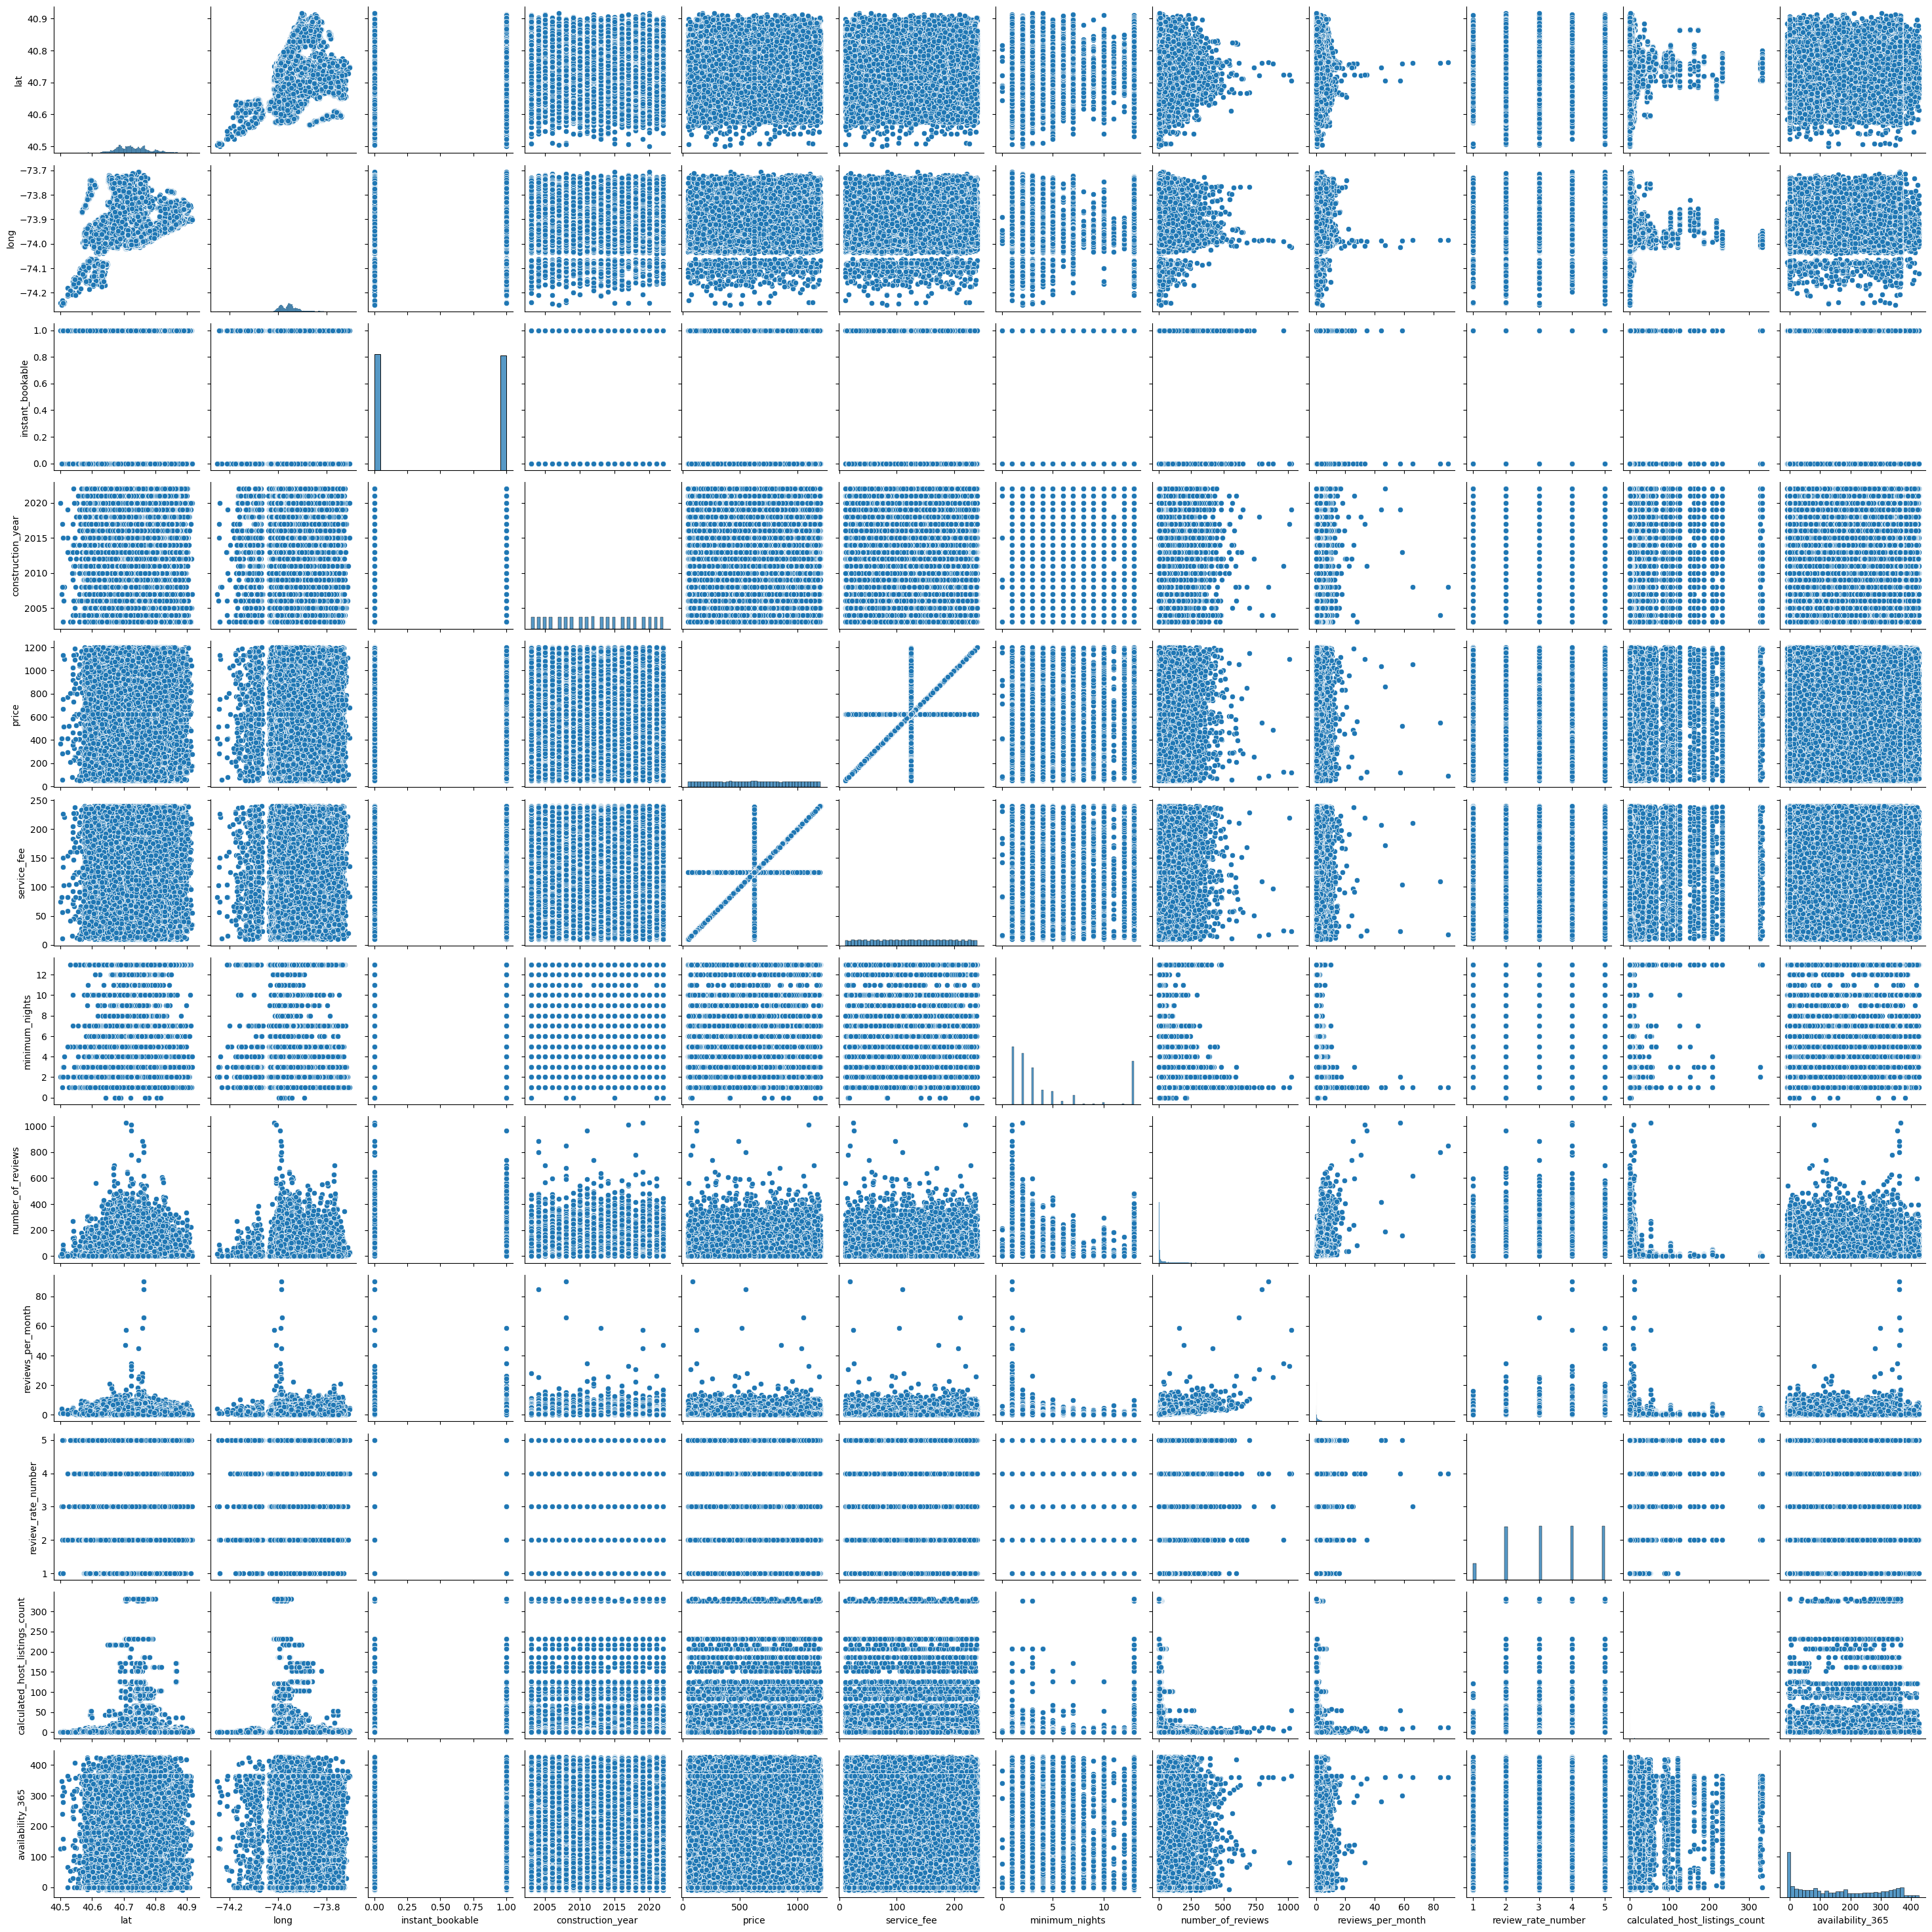

In [ ]:
# Hacemos un Pairplot para ver todas las correlaciones
sns.pairplot(df)
plt.show();

* multivariante: corr en heatmap, pairplot

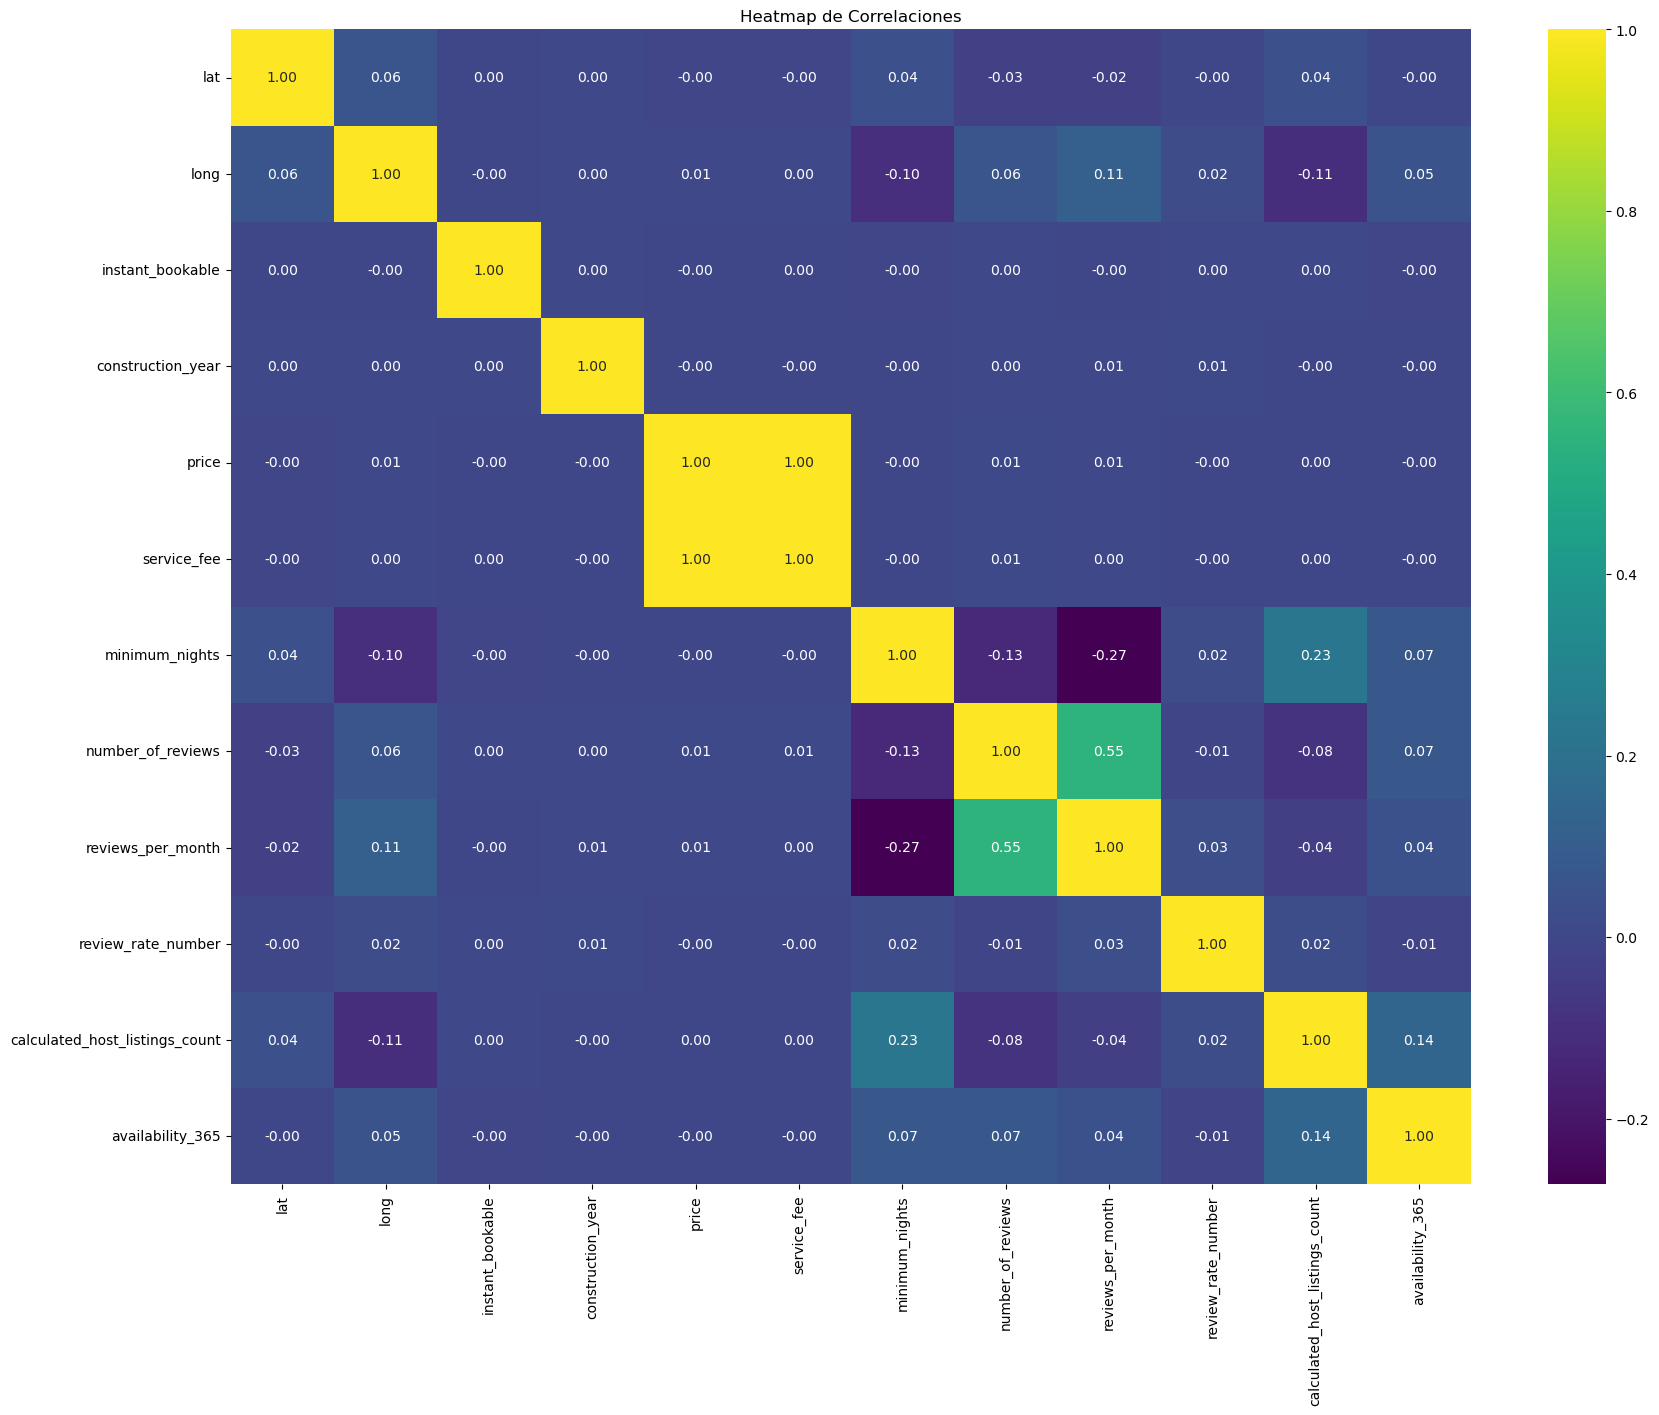

In [ ]:
# Matriz de correlación
plt.figure(figsize=(20, 15))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='viridis', fmt=".2f",)
plt.title("Heatmap de Correlaciones")
plt.show()

# El Pairplot esta realizado arriba

#### Preprocesados (20%)
* numéricas: imputer, scaler, transformer
    * Requisito: hacer los preprocesados con Scikit Learn en lugar de métodos de pandas

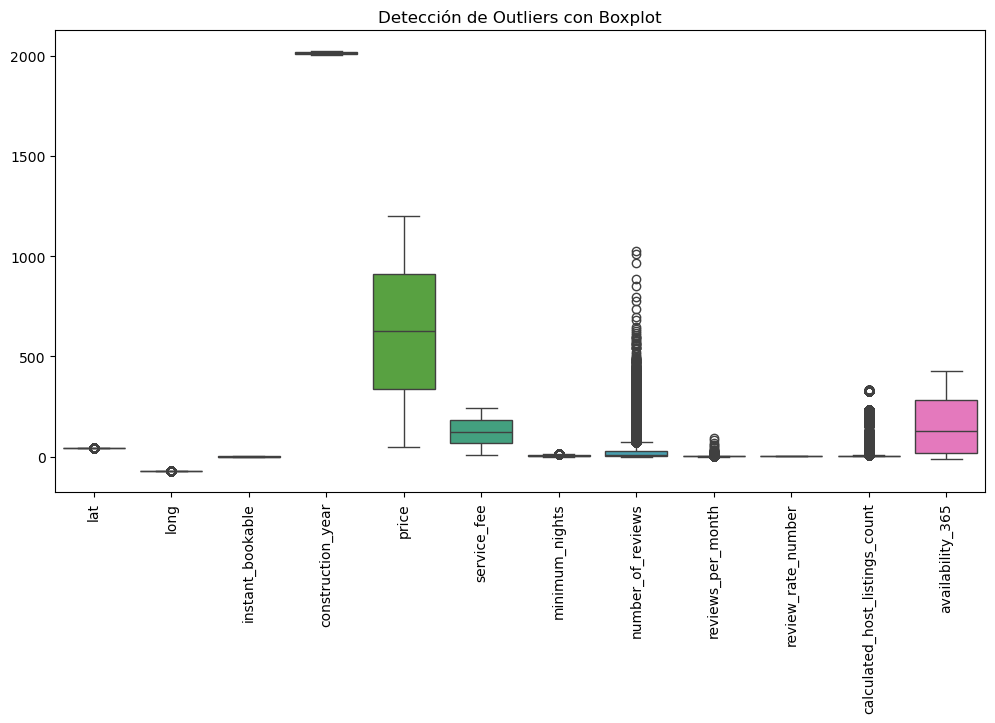

In [ ]:
# Vemos outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title("Detección de Outliers con Boxplot")
plt.show()

In [ ]:
# Con un pipeline
columnas_numericas = df.select_dtypes(include=['number']).columns
print(columnas_numericas)

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Imputar valores NaN con la mediana
    ('scaler', RobustScaler())  # Escalar usando mediana y rango intercuartil (IQR)
])

# Aplicamos a las columnas numéricas del DataFrame
df[columnas_numericas] = pipeline.fit_transform(df[columnas_numericas])

print(df)

Index(['lat', 'long', 'construction_year', 'price', 'service_fee',
       'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'review_rate_number', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')
      host_identity_verified neighbourhood_group       neighbourhood  \
0                unconfirmed            Brooklyn          Kensington   
1                   verified           Manhattan             Midtown   
2                unconfirmed           Manhattan              Harlem   
3                unconfirmed            Brooklyn        Clinton Hill   
4                   verified           Manhattan         East Harlem   
...                      ...                 ...                 ...   
69300               verified            Brooklyn            Bushwick   
69301            unconfirmed            Brooklyn        Williamsburg   
69302               verified           Manhattan     Upper West Side   
69303               verified     

 * categóricas: imputer, encoder

In [58]:
columnas_categoricas = df.select_dtypes(exclude=['number']).columns

# Pipeline para las columnas categóricas
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar valores NaN con la moda
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, max_categories=10))  # Codificar en variables dummies
])

# Aplicaos el Pipeline solo a las columnas categóricas
df_cat_transformed = cat_pipeline.fit_transform(df[columnas_categoricas])

# Convertimos a DataFrame y nos aseguramos que mantiene el índice original
df_cat_transformed = pd.DataFrame(df_cat_transformed, 
                                  columns=cat_pipeline.named_steps['encoder'].get_feature_names_out(columnas_categoricas),
                                  index=df.index)

# Reemplazamos las columnas categóricas originales con las nuevas
df = df.drop(columns=columnas_categoricas)  # Elimina columnas categóricas originales
df = pd.concat([df, df_cat_transformed], axis=1)  # Fusiona con el DF original

print("\nDataFrame Final (Imputado y Codificado para Categóricas)")
print(df.head())


DataFrame Final (Imputado y Codificado para Categóricas)
        lat      long  construction_year     price  service_fee  \
0 -1.013075 -0.349737           0.888889  0.596615     0.597421   
1  0.417442 -0.571484          -0.555556 -0.843944    -0.849948   
2  1.164173  0.242949          -0.777778 -0.008280    -0.007842   
3 -0.505594 -0.104454          -0.777778 -0.448839    -0.446439   
4  1.022510  0.202295          -0.333333 -0.735553    -0.735913   

   minimum_nights  number_of_reviews  reviews_per_month  review_rate_number  \
0            1.75           0.068966          -0.405594                 0.5   
1            2.50           1.310345          -0.286713                 0.5   
2            0.00          -0.241379           0.000000                 1.0   
3            2.50           9.068966           2.692308                 0.5   
4            1.75           0.068966          -0.482517                 0.0   

   calculated_host_listings_count  ...  house_rules_#NAME?  \
0 

#### Clustering y siluetas (10 %)
* Crear una columna cluster usando KMeans o cualquier otro algoritmo de Clustering
* Usar esa columna para hacer algún gráfico EDA como hue para colorear con scatterplot

* feature selection (10%)
    * SelectKBest para filtrar las mejores columnas y probar
    * PCA 

* Regresión (20%):
    * Predecir la columna 'price'
* Clasificación multiclase (20%)
    * Predecir la columna 'room_type'
* Comparar resultados de modelos con validación cruzada (10 %)
    * Mostrar un dataframe de resultados con las métricas calculadas
    * Opcional: mostrar boxplot de los resultados de validación cruzada como tiempos de ejecución y predicción y métricas
